Runs an wasserstein-advarsarial autencoder on our images

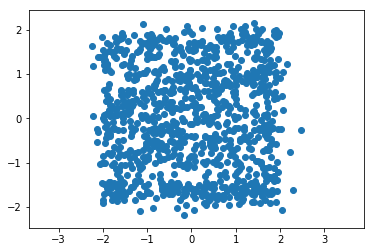

[100] loss: 0.020802 minimaxLoss: 0.500111 advLoss: -0.000012 time: 0.90
[100] loss: 0.019345 minimaxLoss: 0.500164 advLoss: -0.000051 time: 0.89
[100] loss: 0.018230 minimaxLoss: 0.500289 advLoss: -0.000136 time: 0.89
[100] loss: 0.019422 minimaxLoss: 0.500234 advLoss: -0.000084 time: 0.93
[100] loss: 0.019527 minimaxLoss: 0.500206 advLoss: -0.000090 time: 0.93
[100] loss: 0.018642 minimaxLoss: 0.500167 advLoss: -0.000169 time: 0.89
[100] loss: 0.018939 minimaxLoss: 0.500076 advLoss: -0.000010 time: 0.92


In [ ]:
import DataProvider as DP
import SimpleLogger as SimpleLogger

import importlib
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
from IPython import display
import time

import models.waaegan as waaegan

import pdb

def opt(): 1
opt.Diters=5
opt.DitersAlt=5
opt.gpu_id=0
opt.myseed = 0
opt.niter=1000
opt.noBN=False
opt.nlatentdim = 2
opt.lrEnc = 0.01
opt.lrDec = 0.01
opt.lrEncD = 0.00001
opt.EncDRatio = 1
opt.batch_size = 64
opt.nepochs = 250
opt.clamp_lower=-0.01
opt.clamp_upper=0.01

DP = importlib.reload(DP)

np.random.seed(opt.myseed)

image_dir = '/root/data/'

opts = {}
opts['verbose'] = True
opts['pattern'] = '*.tif_flat.png'
opts['out_size'] = [64, 64]

data_path = './data_' + str(opts['out_size'][0]) + 'x' + str(opts['out_size'][1]) + '.pyt'

if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(image_dir, opts)
    torch.save(dp, data_path)


%matplotlib inline
def imshow(img):
#     img = img / 2 + 0.5 # unnormalize

    img = img.numpy()
    if img.ndim == 3:
        img = np.expand_dims(img, 0)
    img = np.transpose(img, [0,2,3,1])
    img = np.concatenate(img[:], 1)

    print(img.shape[0]*10)
    print(img.shape[1]*10)    
    fig = plt.figure(figsize = [img.shape[0]/2, img.shape[1]/2])
    

    ax = fig.add_subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)    
    
    

enc = waaegan.Enc(opt.nlatentdim)
dec = waaegan.Dec(opt.nlatentdim)
encD = waaegan.EncD(opt.nlatentdim)

enc.apply(weights_init)
dec.apply(weights_init)
encD.apply(weights_init)

gpu_id = opt.gpu_id
nlatentdim = opt.nlatentdim

enc.cuda(gpu_id)
dec.cuda(gpu_id)
encD.cuda(gpu_id)

    
criterion = nn.BCELoss()

optEnc = optim.RMSprop(enc.parameters(), lr=opt.lrEnc)
optDec = optim.RMSprop(dec.parameters(), lr=opt.lrDec)
optEncD = optim.RMSprop(encD.parameters(), lr=opt.lrEncD)

ndat = dp.get_n_train()
ndat = 1000

logger = SimpleLogger.SimpleLogger(('epoch', 'reconLoss', 'minimaxLoss', 'advLoss', 'time'), '[%d] loss: %.6f minimaxLoss: %.6f advLoss: %.6f time: %.2f')

one = torch.FloatTensor([1]).cuda(gpu_id)
mone = one * -1

gen_iterations = 0
for epoch in range(opt.nepochs): # loop over the dataset multiple times

    rand_inds = np.random.permutation(ndat)
    inds = (rand_inds[i:i+opt.batch_size] for i in range(0, len(rand_inds), opt.batch_size))
    
    zAll = list()
    
#     recon_loss = 0.0
#     latent_loss = 0.0
#     minimax_loss = 0.0
    
    c = 0
    for i in inds:
        start = time.time()
        c += 1
        
        batsize = len(i)
        
        
#         #pick a distribution that is obvious when you plot it
        
        yReal = Variable(torch.ones(batsize)).cuda(gpu_id)
        yFake = Variable(torch.zeros(batsize)).cuda(gpu_id)

        
        # zero the parameter gradients

        
        ###update the discriminator
        #maximize log(AdvZ(z)) + log(1 - AdvZ(Enc(x)))
        for p in encD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update


        # train the discriminator Diters times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = opt.DitersAlt
        else:
            Diters = opt.Diters
        j = 0

        rand_inds_encD = np.random.permutation(ndat)
        niter = len(range(0, len(rand_inds_encD), opt.batch_size))
        inds_encD = (rand_inds_encD[i:i+opt.batch_size] for i in range(0, len(rand_inds_encD), opt.batch_size))
        
        while j < Diters and j < niter:
            j += 1

            # clamp parameters to a cube
            for p in encD.parameters():
                p.data.clamp_(opt.clamp_lower, opt.clamp_upper)
                
            x = Variable(dp.get_images(next(inds_encD),'train')).cuda(gpu_id)
            
            zFake = enc(x)
            zReal = Variable(torch.Tensor(batsize, nlatentdim).uniform_(-2, 2)).cuda(gpu_id)
            
            optEnc.zero_grad()
            optEncD.zero_grad()

            # train with real
            errD_real = encD(zReal)
            errD_real.backward(one)

            # train with fake
            errD_fake = encD(zFake)
            errD_fake.backward(mone)
            latentLoss = errD_real - errD_fake
            optEncD.step()
            
        optEnc.zero_grad()
        optDec.zero_grad()
        optEncD.zero_grad()  
        
#         x = Variable(dp.get_images(i, 'train')).cuda(gpu_id)
        
        zFake = enc(x)
        xHat = dec(zFake)
    
        reconLoss = criterion(xHat, x)
        reconLoss.backward(retain_variables=True)
        
        for p in encD.parameters():
            p.requires_grad = False
        
        minimaxLoss = encD(zFake)
        minimaxLoss.backward(one*opt.EncDRatio)
        

        optEnc.step()
        optDec.step()

        zAll.append(zFake.data)
        
        stop = time.time()
        deltaT = stop-start
        
        logger.add((epoch+1, reconLoss.data[0], minimaxLoss.data[0][0], latentLoss.data[0][0], deltaT))

    gen_iterations += 1
    zAll = torch.cat(zAll,0).cpu().numpy()

    plt.gca().cla() 
    plt.scatter(zAll[:,0], zAll[:,1])
    plt.xlim([-4, 4]) 
    plt.ylim([-4, 4])     
    plt.axis('equal')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
        
#     optEnc.param_groups[0]['lr'] = learningRate*(0.999**epoch)
#     optDec.param_groups[0]['lr'] = learningRate*(0.999**epoch)
#     optEncD.param_groups[0]['lr'] = learningRate*(0.999**epoch)
                  
                  
print('Finished Training')

In [ ]:
latentLoss.data[0][0]